In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
%matplotlib inline

In [131]:
import imghdr
import colorsys
import random

import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras import backend as K

from functools import reduce

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.

    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = float(image_shape[0])
    width = float(image_shape[1])
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def get_colors_for_classes(num_classes):
    """Return list of random colors for number of classes given."""
    # Use previously generated colors if num_classes is the same.
    if (hasattr(get_colors_for_classes, "colors") and
            len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    get_colors_for_classes.colors = colors  # Save colors for future calls.
    return colors


def draw_boxes(image, boxes, box_classes, class_names, scores=None):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    #image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))
    plt.figure(figsize = (16,8))
    font = ImageFont.truetype(
        font='/content/drive/MyDrive/DL_Project/font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            label = '{} ({:.2f}m )'.format(box_class, score)

        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)

In [3]:
"""Darknet19 Model Defined in Keras."""
import functools
from functools import partial

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


# Partial wrapper for Convolution2D with static default argument.
_DarknetConv2D = partial(Conv2D, padding='same')


@functools.wraps(Conv2D)
def DarknetConv2D(*args, **kwargs):
    """Wrapper to set Darknet weight regularizer for Convolution2D."""
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs.update(kwargs)
    return _DarknetConv2D(*args, **darknet_conv_kwargs)


def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))


def bottleneck_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3 convolutions."""
    return compose(
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))


def bottleneck_x2_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3, 1x1, 3x3 convolutions."""
    return compose(
        bottleneck_block(outer_filters, bottleneck_filters),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))


def darknet_body():
    """Generate first 18 conv layers of Darknet-19."""
    return compose(
        DarknetConv2D_BN_Leaky(32, (3, 3)),
        MaxPooling2D(),
        DarknetConv2D_BN_Leaky(64, (3, 3)),
        MaxPooling2D(),
        bottleneck_block(128, 64),
        MaxPooling2D(),
        bottleneck_block(256, 128),
        MaxPooling2D(),
        bottleneck_x2_block(512, 256),
        MaxPooling2D(),
        bottleneck_x2_block(1024, 512))


def darknet19(inputs):
    """Generate Darknet-19 model for Imagenet classification."""
    body = darknet_body()(inputs)
    logits = DarknetConv2D(1000, (1, 1), activation='softmax')(body)
    return Model(inputs, logits)


In [4]:
"""YOLO_v2 Model Defined in Keras."""
import sys

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

sys.path.append('..')

voc_anchors = np.array(
    [[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]])

voc_classes = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]


def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    # Import currently required to make Lambda work.
    # See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
    import tensorflow as tf
    return tf.nn.space_to_depth(x, block_size=2)


def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.

    Note: For Lambda with TensorFlow backend, output shape may not be needed.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])

def yolo_body(inputs, num_anchors, num_classes):
    """Create YOLO_V2 model CNN body in Keras."""
    darknet = Model(inputs, darknet_body()(inputs))
    conv20 = compose(
        DarknetConv2D_BN_Leaky(1024, (3, 3)),
        DarknetConv2D_BN_Leaky(1024, (3, 3)))(darknet.output)

    conv13 = darknet.layers[43].output
    conv21 = DarknetConv2D_BN_Leaky(64, (1, 1))(conv13)
    # TODO: Allow Keras Lambda to use func arguments for output_shape?
    conv21_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth')(conv21)

    x = concatenate([conv21_reshaped, conv20])
    x = DarknetConv2D_BN_Leaky(1024, (3, 3))(x)
    x = DarknetConv2D(num_anchors * (num_classes + 5), (1, 1))(x)
    return Model(inputs, x)


def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    # Static generation of conv_index:
    # conv_index = np.array([_ for _ in np.ndindex(conv_width, conv_height)])
    # conv_index = conv_index[:, [1, 0]]  # swap columns for YOLO ordering.
    # conv_index = K.variable(
    #     conv_index.reshape(1, conv_height, conv_width, 1, 2))
    # feats = Reshape(
    #     (conv_dims[0], conv_dims[1], num_anchors, num_classes + 5))(feats)

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs


def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


def yolo_loss(args,
              anchors,
              num_classes,
              rescore_confidence=False,
              print_loss=False):
    """YOLO localization loss function.

    Parameters
    ----------
    yolo_output : tensor
        Final convolutional layer features.

    true_boxes : tensor
        Ground truth boxes tensor with shape [batch, num_true_boxes, 5]
        containing box x_center, y_center, width, height, and class.

    detectors_mask : array
        0/1 mask for detector positions where there is a matching ground truth.

    matching_true_boxes : array
        Corresponding ground truth boxes for positive detector positions.
        Already adjusted for conv height and width.

    anchors : tensor
        Anchor boxes for model.

    num_classes : int
        Number of object classes.

    rescore_confidence : bool, default=False
        If true then set confidence target to IOU of best predicted box with
        the closest matching ground truth box.

    print_loss : bool, default=False
        If True then use a tf.Print() to print the loss components.

    Returns
    -------
    mean_loss : float
        mean localization loss across minibatch
    """
    (yolo_output, true_boxes, detectors_mask, matching_true_boxes) = args
    num_anchors = len(anchors)
    object_scale = 5
    no_object_scale = 1
    class_scale = 1
    coordinates_scale = 1
    pred_xy, pred_wh, pred_confidence, pred_class_prob = yolo_head(
        yolo_output, anchors, num_classes)

    # Unadjusted box predictions for loss.
    # TODO: Remove extra computation shared with yolo_head.
    yolo_output_shape = K.shape(yolo_output)
    feats = K.reshape(yolo_output, [
        -1, yolo_output_shape[1], yolo_output_shape[2], num_anchors,
        num_classes + 5
    ])
    pred_boxes = K.concatenate(
        (K.sigmoid(feats[..., 0:2]), feats[..., 2:4]), axis=-1)

    # TODO: Adjust predictions by image width/height for non-square images?
    # IOUs may be off due to different aspect ratio.

    # Expand pred x,y,w,h to allow comparison with ground truth.
    # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
    pred_xy = K.expand_dims(pred_xy, 4)
    pred_wh = K.expand_dims(pred_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half

    true_boxes_shape = K.shape(true_boxes)

    # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
    true_boxes = K.reshape(true_boxes, [
        true_boxes_shape[0], 1, 1, 1, true_boxes_shape[1], true_boxes_shape[2]
    ])
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    # Find IOU of each predicted box with each ground truth box.
    true_wh_half = true_wh / 2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half

    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    # Best IOUs for each location.
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious)

    # A detector has found an object if IOU > thresh for some true box.
    object_detections = K.cast(best_ious > 0.6, K.dtype(best_ious))

    # TODO: Darknet region training includes extra coordinate loss for early
    # training steps to encourage predictions to match anchor priors.

    # Determine confidence weights from object and no_object weights.
    # NOTE: YOLO does not use binary cross-entropy here.
    no_object_weights = (no_object_scale * (1 - object_detections) *
                         (1 - detectors_mask))
    no_objects_loss = no_object_weights * K.square(-pred_confidence)

    if rescore_confidence:
        objects_loss = (object_scale * detectors_mask *
                        K.square(best_ious - pred_confidence))
    else:
        objects_loss = (object_scale * detectors_mask *
                        K.square(1 - pred_confidence))
    confidence_loss = objects_loss + no_objects_loss

    # Classification loss for matching detections.
    # NOTE: YOLO does not use categorical cross-entropy loss here.
    matching_classes = K.cast(matching_true_boxes[..., 4], 'int32')
    matching_classes = K.one_hot(matching_classes, num_classes)
    classification_loss = (class_scale * detectors_mask *
                           K.square(matching_classes - pred_class_prob))

    # Coordinate loss for matching detection boxes.
    matching_boxes = matching_true_boxes[..., 0:4]
    coordinates_loss = (coordinates_scale * detectors_mask *
                        K.square(matching_boxes - pred_boxes))

    confidence_loss_sum = K.sum(confidence_loss)
    classification_loss_sum = K.sum(classification_loss)
    coordinates_loss_sum = K.sum(coordinates_loss)
    total_loss = 0.5 * (
        confidence_loss_sum + classification_loss_sum + coordinates_loss_sum)
    if print_loss:
        total_loss = tf.Print(
            total_loss, [
                total_loss, confidence_loss_sum, classification_loss_sum,
                coordinates_loss_sum
            ],
            message='yolo_loss, conf_loss, class_loss, box_coord_loss:')

    return total_loss


def yolo(inputs, anchors, num_classes):
    """Generate a complete YOLO_v2 localization model."""
    num_anchors = len(anchors)
    body = yolo_body(inputs, num_anchors, num_classes)
    outputs = yolo_head(body.output, anchors, num_classes)
    return outputs


def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=.6):
    """Filter YOLO boxes based on object and class confidence."""
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    prediction_mask = box_class_scores >= threshold

    # TODO: Expose tf.boolean_mask to Keras backend?
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)
    return boxes, scores, classes


def yolo_eval(yolo_outputs,
              image_shape,
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        boxes, box_confidence, box_class_probs, threshold=score_threshold)

    # Scale boxes back to original image shape.
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims

    # TODO: Something must be done about this ugly hack!
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_index = tf.image.non_max_suppression(
        boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, nms_index)
    scores = K.gather(scores, nms_index)
    classes = K.gather(classes, nms_index)
    return boxes, scores, classes


def preprocess_true_boxes(true_boxes, anchors, image_size):
    """Find detector in YOLO where ground truth box should appear.

    Parameters
    ----------
    true_boxes : array
        List of ground truth boxes in form of relative x, y, w, h, class.
        Relative coordinates are in the range [0, 1] indicating a percentage
        of the original image dimensions.
    anchors : array
        List of anchors in form of w, h.
        Anchors are assumed to be in the range [0, conv_size] where conv_size
        is the spatial dimension of the final convolutional features.
    image_size : array-like
        List of image dimensions in form of h, w in pixels.

    Returns
    -------
    detectors_mask : array
        0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        that should be compared with a matching ground truth box.
    matching_true_boxes: array
        Same shape as detectors_mask with the corresponding ground truth box
        adjusted for comparison with predicted parameters at training time.
    """
    height, width = image_size
    num_anchors = len(anchors)
    # Downsampling factor of 5x 2-stride max_pools == 32.
    # TODO: Remove hardcoding of downscaling calculations.
    assert height % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    assert width % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    conv_height = height // 32
    conv_width = width // 32
    num_box_params = true_boxes.shape[1]
    detectors_mask = np.zeros(
        (conv_height, conv_width, num_anchors, 1), dtype=np.float32)
    matching_true_boxes = np.zeros(
        (conv_height, conv_width, num_anchors, num_box_params),
        dtype=np.float32)

    for box in true_boxes:
        # scale box to convolutional feature spatial dimensions
        box_class = box[4:5]
        box = box[0:4] * np.array(
            [conv_width, conv_height, conv_width, conv_height])
        i = np.floor(box[1]).astype('int')
        j = np.floor(box[0]).astype('int')
        best_iou = 0
        best_anchor = 0
        for k, anchor in enumerate(anchors):
            # Find IOU between box shifted to origin and anchor box.
            box_maxes = box[2:4] / 2.
            box_mins = -box_maxes
            anchor_maxes = (anchor / 2.)
            anchor_mins = -anchor_maxes

            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchor_maxes)
            intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_area = intersect_wh[0] * intersect_wh[1]
            box_area = box[2] * box[3]
            anchor_area = anchor[0] * anchor[1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            if iou > best_iou:
                best_iou = iou
                best_anchor = k

        if best_iou > 0:
            detectors_mask[i, j, best_anchor] = 1
            adjusted_box = np.array(
                [
                    box[0] - j, box[1] - i,
                    np.log(box[2] / anchors[best_anchor][0]),
                    np.log(box[3] / anchors[best_anchor][1]), box_class
                ],
                dtype=np.float32)
            matching_true_boxes[i, j, best_anchor] = adjusted_box
    return detectors_mask, matching_true_boxes


In [5]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    ### START CODE HERE
    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = box_confidence * box_class_probs

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = (box_class_scores >= threshold)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    ### END CODE HERE
    
    return scores, boxes, classes

In [6]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    ### START CODE HERE
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ##(≈ 7 lines)
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max(0,xi2 - xi1 )
    inter_height = max(0,yi2 - yi1)
    inter_area = inter_width * inter_height
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ## (≈ 3 lines)
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    ### END CODE HERE
    
    return iou

In [7]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    ### START CODE HERE
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    ### END CODE HERE

    
    return scores, boxes, classes

In [8]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [9]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs =  yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    ### END CODE HERE
    
    return scores, boxes, classes

In [14]:
class_names = read_classes("/content/drive/MyDrive/DL_Project/coco_classes.txt")
anchors = read_anchors("/content/drive/MyDrive/DL_Project/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [15]:
yolo_model = load_model("/content/drive/MyDrive/DL_Project/", compile=False)

/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:299: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')
/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:304: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  'output_shape_type')


In [36]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [41]:
import torch
import torch.nn as nn


In [42]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 conv layer with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def get_incoming_shape(incoming):
    size = incoming.size()
    # returns the incoming data shape as a list
    return [size[0], size[1], size[2], size[3]]


def interleave(tensors, axis):
    # change the first element (batch_size to -1)
    old_shape = get_incoming_shape(tensors[0])[1:]
    new_shape = [-1] + old_shape

    # double 1 dimension
    new_shape[axis] *= len(tensors)

    # pack the tensors on top of each other
    stacked = torch.stack(tensors, axis+1)

    # reshape and return
    reshaped = stacked.view(new_shape)
    return reshaped


class UnpoolingAsConvolution(nn.Module):
    def __init__(self, inplanes, planes):
        super(UnpoolingAsConvolution, self).__init__()

        # interleaving convolutions
        self.conv_A = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 3), stride=1, padding=1)
        self.conv_B = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 3), stride=1, padding=0)
        self.conv_C = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 2), stride=1, padding=0)
        self.conv_D = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 2), stride=1, padding=0)

    def forward(self, x):
        output_a = self.conv_A(x)

        padded_b = nn.functional.pad(x, (1, 1, 0, 1))
        output_b = self.conv_B(padded_b)

        padded_c = nn.functional.pad(x, (0, 1, 1, 1))
        output_c = self.conv_C(padded_c)

        padded_d = nn.functional.pad(x, (0, 1, 0, 1))
        output_d = self.conv_D(padded_d)

        left = interleave([output_a, output_b], axis=2)
        right = interleave([output_c, output_d], axis=2)
        y = interleave([left, right], axis=3)
        return y


class UpProjection(nn.Module):
    def __init__(self, inplanes, planes):
        super(UpProjection, self).__init__()

        self.unpool_main = UnpoolingAsConvolution(inplanes, planes)
        self.unpool_res = UnpoolingAsConvolution(inplanes, planes)

        self.main_branch = nn.Sequential(
            self.unpool_main,
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=False),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes)
        )

        self.residual_branch = nn.Sequential(
            self.unpool_res,
            nn.BatchNorm2d(planes),
        )

        self.relu = nn.ReLU(inplace=False)

    def forward(self, input_data):
        x = self.main_branch(input_data)
        res = self.residual_branch(input_data)
        x += res
        x = self.relu(x)
        return x


class ConConv(nn.Module):
    def __init__(self, inplanes_x1, inplanes_x2, planes):
        super(ConConv, self).__init__()
        self.conv = nn.Conv2d(inplanes_x1 + inplanes_x2, planes, kernel_size=1, bias=True)

    def forward(self, x1, x2):
        x1 = torch.cat([x2, x1], dim=1)
        x1 = self.conv(x1)
        return x1


class ResnetUnetHybrid(nn.Module):
    def __init__(self, block, layers):
        self.inplanes = 64

        # resnet layers
        super(ResnetUnetHybrid, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # additional up projection layers parts
        self.conv2 = nn.Conv2d(2048, 1024, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(1024)

        self.up_proj1 = UpProjection(1024, 512)
        self.up_proj2 = UpProjection(512, 256)
        self.up_proj3 = UpProjection(256, 128)
        self.up_proj4 = UpProjection(128, 64)

        self.drop = nn.Dropout(0.5, False)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=True)

        # padding + concat for unet stuff
        self.con_conv1 = ConConv(1024, 512, 512)
        self.con_conv2 = ConConv(512, 256, 256)
        self.con_conv3 = ConConv(256, 128, 128)
        self.con_conv4 = ConConv(64, 64, 64)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x_to_conv4 = self.relu(x)

        x = self.maxpool(x_to_conv4)
        x_to_conv3 = self.layer1(x)
        x_to_conv2 = self.layer2(x_to_conv3)
        x_to_conv1 = self.layer3(x_to_conv2)
        x = self.layer4(x_to_conv1)

        # additional layers
        x = self.conv2(x)
        x = self.bn2(x)

        # up project part
        x = self.up_proj1(x)
        x = self.con_conv1(x, x_to_conv1)

        x = self.up_proj2(x)
        x = self.con_conv2(x, x_to_conv2)

        x = self.up_proj3(x)
        x = self.con_conv3(x, x_to_conv3)

        x = self.up_proj4(x)
        x = self.con_conv4(x, x_to_conv4)

        x = self.drop(x)
        x = self.conv3(x)
        x = self.relu(x)

        return x

    @classmethod
    def load_pretrained(cls, device, load_path='hyb_net_weights.model'):
        model = cls(Bottleneck, [3, 4, 6, 3])

        # download the weights if they are not present
        if not os.path.exists(load_path):
            print('Downloading model weights...')
            os.system('wget https://www.dropbox.com/s/amad4ko9opi4kts/hyb_net_weights.model')

        model = model.to(device)
        model.load_state_dict(torch.load(load_path, map_location=device))

        return model


In [43]:
HEIGHT = 256
WIDTH = 320


def scale_image(img, scale=None):
    """Resize/scale an image. If a scale is not provided, scale it closer to HEIGHT x WIDTH."""
    # if scale is None, scale to the longer size
    if scale is None:
        scale = max(WIDTH / img.shape[1], HEIGHT / img.shape[0])

    new_size = (math.ceil(img.shape[1] * scale), math.ceil(img.shape[0] * scale))
    image = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    return image


def center_crop(img):
    """Center crop an image to HEIGHT x WIDTH."""
    corner = ((img.shape[0] - HEIGHT) // 2, (img.shape[1] - WIDTH) // 2)
    img = img[corner[0]:corner[0] + HEIGHT, corner[1]:corner[1] + WIDTH]
    return img


def img_transform(img):
    """Normalize an image."""
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = data_transform(img)
    return img


def show_img_and_pred(img, depth):
    """Plot an image and a corresponding prediction next to each other."""
    plt.figure(figsize = (12 ,6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    pred = np.transpose(depth, (1, 2, 0))
    pred = pred [ : , : , 0]
    plt.imshow(pred ,  cmap=plt.cm.gist_rainbow)

    plt.show()
    


def depth_to_grayscale(depth, max_dist=10.0):
    """Transform a prediction into a grayscale 8-bit image."""
    depth = np.transpose(depth, (1, 2, 0))
    depth[depth > max_dist] = max_dist
    depth = depth / max_dist

    depth = np.array(depth * 255.0, dtype=np.uint8)
    depth = cv2.resize(depth, (WIDTH, HEIGHT))

    bgr_depth_img = cv2.cvtColor(depth, cv2.COLOR_GRAY2BGR)
    bgr_depth_img = np.clip(bgr_depth_img, 0, 255)
    return bgr_depth_img


In [48]:
from torchvision import transforms


In [82]:
def predict_img(img):
    """Inference a single image."""
    # switch to CUDA device if possible
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Use GPU: {}'.format(str(device) != 'cpu'))

    # load model
    print('Loading model...')
    model = ResnetUnetHybrid.load_pretrained(device=device)
    model.eval()

    H = img.shape[1]
    W = img.shape[0]
    img = scale_image(img)
    img = center_crop(img)
    inp = img_transform(img)
    inp = inp[None, :, :, :].to(device)

    # inference
    print('Running the image through the network...')
    output_ = model(inp)

    # transform and plot the results
    output = output_.cpu()[0].data.numpy()
    show_img_and_pred(img, output)

    resized_image = cv2.resize(output[0], ( H , W) , interpolation=cv2.INTER_NEAREST)

    return img , resized_image

Use GPU: True
Loading model...
Running the image through the network...


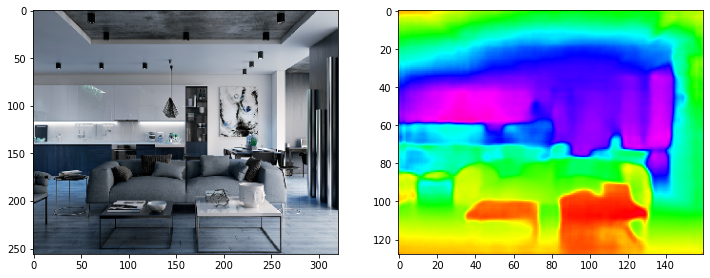

In [112]:
import cv2
a = cv2.imread('/content/drive/MyDrive/DL_Project/in_images/indoor.jpg')
orig , predicted = predict_img(a)

In [115]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image

    image, image_data = preprocess_image("/content/drive/MyDrive/DL_Project/in_images/"+image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)


    return out_scores, out_boxes, out_classes , image

In [116]:
out_scores, out_boxes, out_classes , image = predict("indoor.jpg")

Found 10 boxes for indoor.jpg


In [117]:
def DEPTH_Calc(xmin,ymin,xmax,ymax ,  pred):
  xmin = math.floor(xmin)
  ymin = math.floor(ymin)
  xmax = math.floor(xmax)
  ymax = math.floor(ymax)
  sum = 0
  num = 1
  for i in range(xmin,xmax +1):
    for j in range(ymin,ymax +1):
      sum += pred[j,i]
  num = (xmax-xmin+1)*(ymax-ymin+1)
  DEPTH = sum/num
  return DEPTH

In [118]:
xmins = out_boxes[: , 0 ]
ymins = out_boxes[: , 1 ]
xmaxs = out_boxes[: , 2 ]
ymaxs = out_boxes[: , 3 ]

In [119]:
out_boxes

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[ 397.7144  ,  354.92365 ,  567.63586 ,  912.2482  ],
       [ 542.1169  ,  494.0949  ,  574.73865 ,  560.2501  ],
       [ 443.49506 , 1101.5189  ,  557.13    , 1229.1476  ],
       [ 435.1274  ,   22.432074,  570.375   ,  256.3774  ],
       [  51.873085,    4.310445,  562.9803  ,  177.38672 ],
       [ 497.3388  ,  766.8868  ,  570.82416 ,  833.35    ],
       [ 459.6554  ,   32.19013 ,  663.332   ,  248.25386 ],
       [ 392.94214 ,  730.49744 ,  424.05148 ,  787.39746 ],
       [ 546.8725  ,  388.2526  ,  581.4901  ,  512.75885 ],
       [ 394.80505 ,  475.64276 ,  435.19208 ,  591.93567 ]],
      dtype=float32)>

In [120]:
import math

In [121]:
DEPTHS = []
for i in range(len(xmins)):
  object_depth = DEPTH_Calc(ymins[i],xmins[i],ymaxs[i],xmaxs[i] , predicted)
  DEPTHS.append(round(object_depth,2))

In [122]:
depthstensor = torch.tensor(DEPTHS)

sofa (3.89m ) (355, 398) (912, 568)
bowl (2.52m ) (494, 542) (560, 575)
chair (4.94m ) (1102, 443) (1229, 557)
chair (4.32m ) (22, 435) (256, 570)
pottedplant (5.53m ) (4, 52) (177, 563)
vase (2.61m ) (767, 497) (833, 571)
chair (3.80m ) (32, 460) (248, 663)
chair (6.86m ) (730, 393) (787, 424)
book (2.33m ) (388, 547) (513, 581)
diningtable (5.04m ) (476, 395) (592, 435)


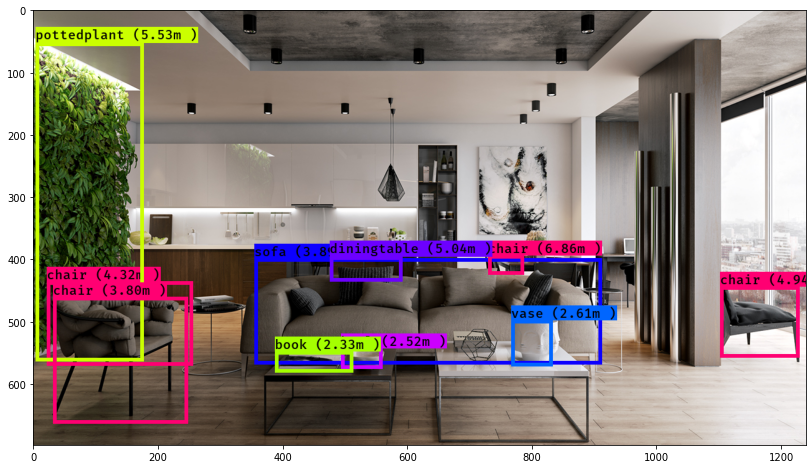

In [132]:
img = draw_boxes(image, out_boxes, out_classes, class_names, depthstensor)
# Save the predicted bounding box on the image
# image.save(os.path.join("/content/drive/MyDrive/DL_Project/out_images", image_file), quality=200)
# Display the results in the notebook
# output_image = Image.open(os.path.join("/content/drive/MyDrive/DL_Project/out_images", image_file))
imshow(img)